In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from tensorflow.keras import layers

E0000 00:00:1753076954.953206      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [ ]:
#Config
INPUT_DIR = Path("./output_wav2vec_precomputed_features")
OUTPUT_DIR = Path("./output_conformer_training_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection', 'NoStutter']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16 # Batch size for each TPU core
EPOCHS = 50
LEARNING_RATE = 1e-4
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./output_cnn_training_tpu")
BEST_MODEL_PATH = OUTPUT_DIR / "best_cnn_model_tpu.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    # We need to pass tpu='local' to tell the resolver where to look for tpu usage on kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    print('Found TPU: ', tpu.master())
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print("TPU successfully initialized.")
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

--- Initializing TPU Strategy ---
Found TPU:  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753076975.315568      10 service.cc:148] XLA service 0x55badc8978d0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753076975.315615      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753076975.315620      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753076975.315623      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753076975.315626      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753076975.315628      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753076975.315631      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753076975.315634      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753076975.315636      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:
print("\n--- Loading all compressed features into RAM... ---")

# Load the compressed .npz files
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']

print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")


--- Loading all compressed features into RAM... ---
All compressed data loaded successfully.
X_train shape: (30778, 150, 768)


In [ ]:
print("\n--- Building tf.data pipeline from in-memory arrays... ---")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


--- Building tf.data pipeline from in-memory arrays... ---
Datasets created successfully.


In [19]:
import gc
gc.collect()

5230

In [ ]:

with strategy.scope():
    print("\n--- Building DNN Model inside TPU Strategy Scope... ---")
    
    # --- Simple DNN Classifier ---
    def build_dnn_classifier(input_shape, num_classes):
        inputs = tf.keras.layers.Input(shape=input_shape)

        # Pooling Layer
        # Collapses the time dimension (150) to create a single feature vector.
        x = tf.keras.layers.GlobalAveragePooling1D()(inputs)

        # a simple DNN Classifier Head a simple DNN
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc', multi_label=True)
            ]
        )
        return model

    model = build_dnn_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)



--- Building DNN Model inside TPU Strategy Scope... ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,534 (900.52 KB)

 Trainable params: 230,534 (900.52 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
print("\n--- Starting Training on TPU... ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


--- Starting Training on TPU... ---
Epoch 1/50


I0000 00:00:1753078133.379642      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16448548073978146903
I0000 00:00:1753078133.843110     919 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1612448149005037348), session_name()
I0000 00:00:1753078136.582809     919 tpu_compile_op_common.cc:245] Compilation of 1612448149005037348 with session name  took 2.739638267s and succeeded
I0000 00:00:1753078136.599440     919 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1612448149005037348), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16448548073978146903", property.function_library_fingerprint = 11454845086052198960, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().

239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2165 - auc: 0.5250 - loss: 0.6234 - precision: 0.3505 - recall: 0.1794

I0000 00:00:1753078144.158466     943 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17688446374238493314), session_name()
I0000 00:00:1753078146.914616     943 tpu_compile_op_common.cc:245] Compilation of 17688446374238493314 with session name  took 2.756113284s and succeeded
I0000 00:00:1753078146.931524     943 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17688446374238493314), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16448548073978146903", property.function_library_fingerprint = 11454845086052198960, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,150,768,;8,6,;", property.guaranteed_constants_size = 0, embedding_

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2166 - auc: 0.5251 - loss: 0.6232 - precision: 0.3506 - recall: 0.1787

I0000 00:00:1753078163.536841      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16179538635803368761
I0000 00:00:1753078163.884308     959 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(10810554079476528199), session_name()
I0000 00:00:1753078164.649702     959 tpu_compile_op_common.cc:245] Compilation of 10810554079476528199 with session name  took 765.311127ms and succeeded
I0000 00:00:1753078164.652571     959 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(10810554079476528199), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16179538635803368761", property.function_library_fingerprint = 6608404248933159840, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap(


Epoch 1: val_auc improved from -inf to 0.59949, saving model to output_dnn_training_tpu/best_dnn_model_tpu.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.2166 - auc: 0.5252 - loss: 0.6232 - precision: 0.3506 - recall: 0.1783 - val_accuracy: 0.2902 - val_auc: 0.5995 - val_loss: 0.5981 - val_precision: 1.0000 - val_recall: 0.0037
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2456 - auc: 0.5762 - loss: 0.5887 - precision: 0.3959 - recall: 0.0488
Epoch 2: val_auc improved from 0.59949 to 0.63920, saving model to output_dnn_training_tpu/best_dnn_model_tpu.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.2457 - auc: 0.5763 - loss: 0.5887 - precision: 0.3962 - recall: 0.0489 - val_accuracy: 0.2875 - val_auc: 0.6392 - val_loss: 0.5902 - val_precision: 0.5781 - val_recall: 0.0551
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2730 - auc: 0.6211 - loss: 0.5701 - precision: 0.4784 - recall: 0.0986
Epoch 3: val_auc improved 


--- Evaluating Model on the Test Set ---


I0000 00:00:1753080040.141885      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:12599209691991127309
E0000 00:00:1753080040.148376      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_3_1/dense_12_1/BiasAdd/ReadVariableOp.
I0000 00:00:1753080040.179645     954 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1224222280778986089), session_name()
I0000 00:00:1753080040.261794     954 tpu_compile_op_common.cc:245] Compilation of 1224222280778986089 with session name  took 82.068062ms and succeeded
I0000 00:00:1753080040.262496     954 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1224222280778986089), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_12599209691991127309", property.function_library_fingerprint = 15070552132351563143, property.mlir_module_finger

67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

I0000 00:00:1753080045.768663      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11839107494264399934
I0000 00:00:1753080045.940373     951 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17241457314736913021), session_name()
I0000 00:00:1753080046.041835     951 tpu_compile_op_common.cc:245] Compilation of 17241457314736913021 with session name  took 101.408618ms and succeeded
I0000 00:00:1753080046.042322     951 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17241457314736913021), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11839107494264399934", property.function_library_fingerprint = 4871330483379442236, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, to

68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step

--- Classification Report (Multi-Label) ---
              precision    recall  f1-score   support

Prolongation       0.75      0.14      0.24      2613
       Block       0.63      0.22      0.33      3501
    SoundRep       0.63      0.20      0.30      1891
     WordRep       0.48      0.35      0.40      1742
Interjection       0.78      0.53      0.63      3344
   NoStutter       0.54      0.40      0.46      1674

   micro avg       0.64      0.31      0.42     14765
   macro avg       0.64      0.31      0.39     14765
weighted avg       0.66      0.31      0.40     14765
 samples avg       0.38      0.31      0.32     14765


--- Generating plots for model training history... ---


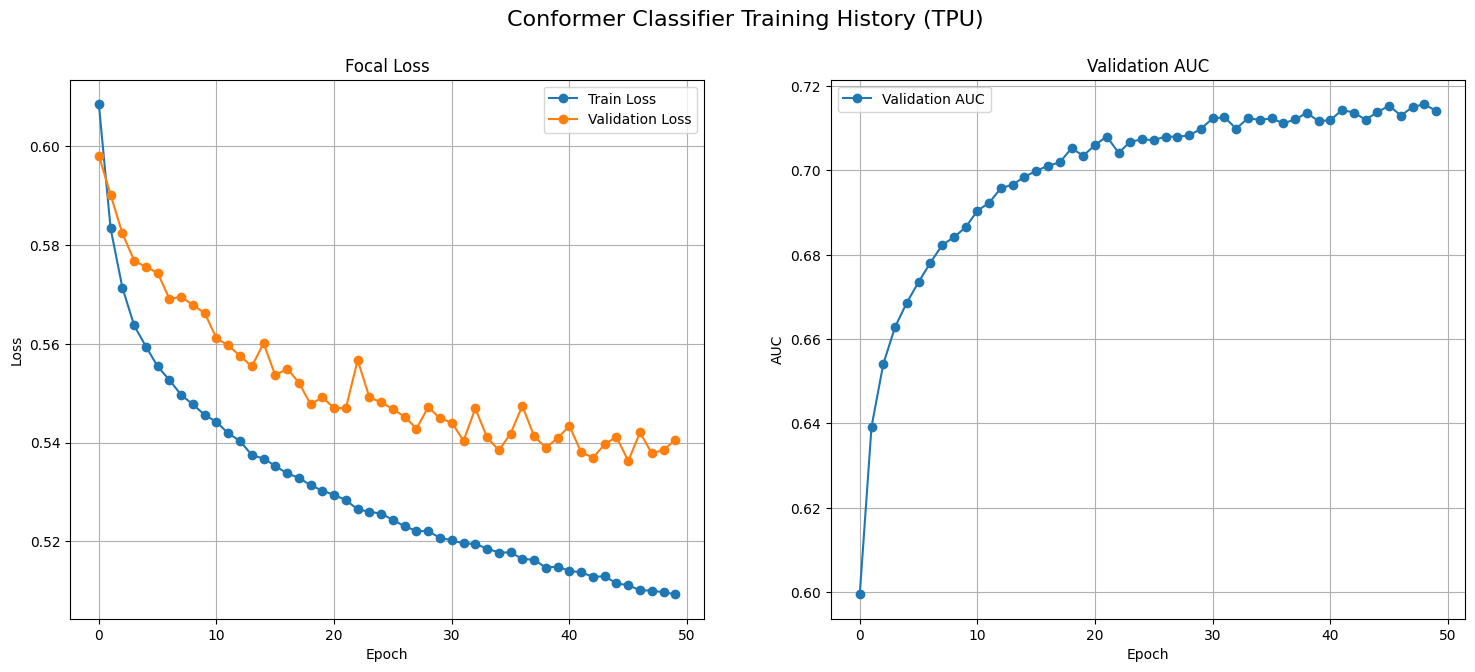


--- Pipeline complete. All outputs saved in 'output_dnn_training_tpu' directory. ---


In [ ]:
print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Classification Report (Multi-Label) ---")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# --- Plotting History ---
print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Conformer Classifier Training History (TPU)', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Focal Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_conformer_tpu.png")
plt.show()

print(f"\n--- Pipeline complete. All outputs saved in '{OUTPUT_DIR}' directory. ---")